# Permutation algorithm

The permalgo is an algorithm that generate time to event data. The data follow the 


## Available scenarios 

The scenario represent the shape of the WCE function. There are four scenarios currently implemented in the survivalGPU library : 

- Exponential scenario

$$ f(u_t) = 7 \cdot \exp\left(\frac{-7.u_t}{365}\right) $$
<div align="center">
  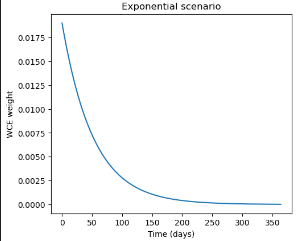
</div>


- Bi-linear scenario

$$ f(u_t) = 
\begin{cases} 
1 - \left(\frac{\frac{u_t}{365}}{\frac{50}{365}}\right) & \text{if } u_t < 50 \\
0 & \text{if } u_t \geq 50
\end{cases} $$

- Early peak scenario


<div align="center">
  Density of a N [0.04; 0.05] normal distribution
</div>

- Inverted U scenario 

<div align="center">
  Density of a N [0.2; 0.06] normal distribution
</div>

u_t correspond to the time (in days) before the time where the dose was taken. All these scenario are normalized so that the sum of all their weights during the observation period is equal to 1. The real shape of the WCE function is equal to the shape of the scenario multiplied by ln(HR_target)



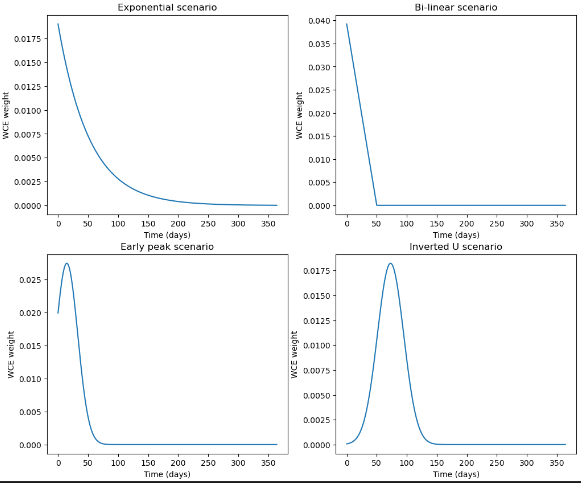

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


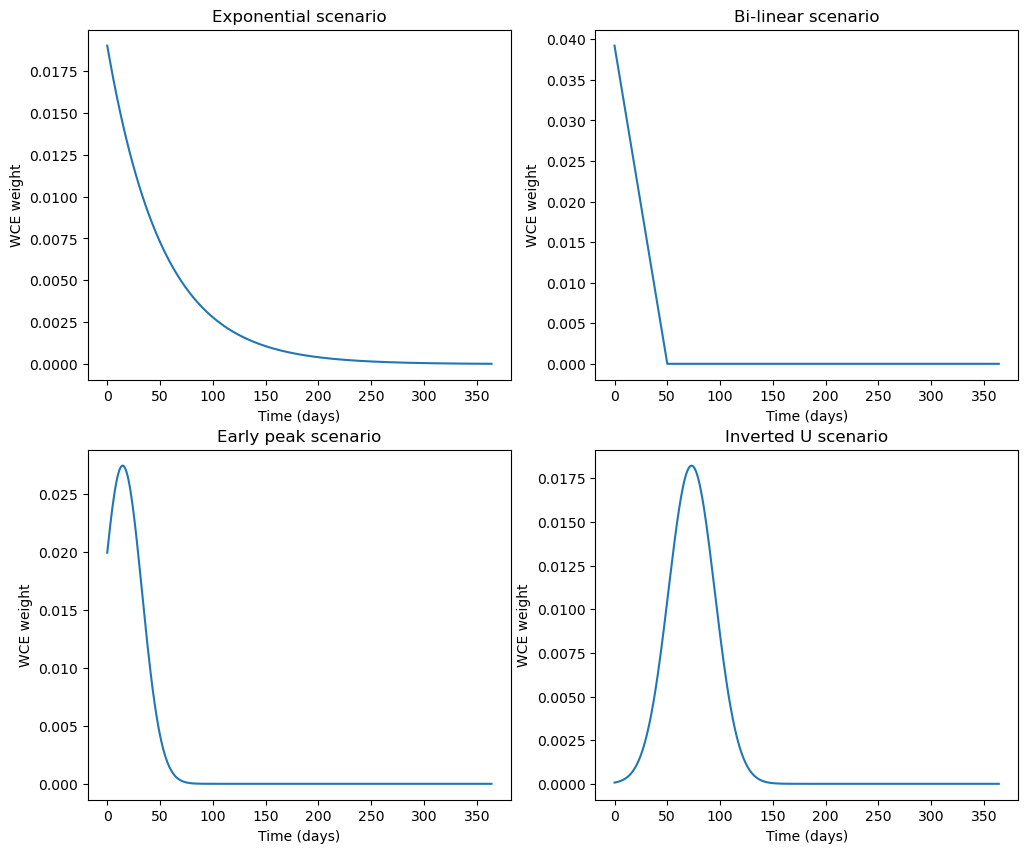

In [1]:
import torch
import os
import sys
import pykeops
import numpy as np
import pykeops

sys.path.append("dev/survivalGPU/python")

os.getcwd()

from survivalgpu.simulation import get_scenario
import matplotlib.pyplot as plt
import numpy as np


exponential_scenario = get_scenario(scenario_name = "exponential_scenario", max_time = 365)
bi_linear_scenario = get_scenario(scenario_name = "bi_linear_scenario", max_time = 365)
early_peak_scenario = get_scenario(scenario_name = "early_peak_scenario", max_time = 365)
inverted_u_scenario = get_scenario(scenario_name = "inverted_u_scenario", max_time = 365)


fig, ax = plt.subplots(2, 2, figsize=(12, 10))
plt.subplot(2,2,1)
plt.plot(np.arange(365), exponential_scenario)
plt.title("Exponential scenario")
plt.xlabel("Time (days)")
plt.ylabel("WCE weight")

plt.subplot(2,2,2)
plt.plot(np.arange(365), bi_linear_scenario)
plt.title("Bi-linear scenario")
plt.xlabel("Time (days)")
plt.ylabel("WCE weight")

plt.subplot(2,2,3)
plt.plot(np.arange(365), early_peak_scenario)
plt.title("Early peak scenario")
plt.xlabel("Time (days)")
plt.ylabel("WCE weight")

plt.subplot(2,2,4)
plt.plot(np.arange(365), inverted_u_scenario)
plt.title("Inverted U scenario")
plt.xlabel("Time (days)")
plt.ylabel("WCE weight")

plt.show()


## Data simulation

**simulate_dataset** : function simulate_dataset that allow to simulate the data, it integrate the function get_scenario 

----

**Args**

- **max_time** : the observation period on which the data is simulated 

- **n_patients** : the number of simulated patients

- **doses** : the doses of drug that can be taken by the patient

- **scenario** : the shape of the WCE function on which the data is simulated

- **HR_target** : the HR of a patient that take 1 dose of the drug everyday for 
the duration of the observation period, compared to a patient that don't take the drug

----
**Returns**

A dataframe with 5 columns

- **patient** : the id of the generated patient

- **start** : the time at the beginning of a unit of time

- **stop** : the time at the end of a unit of time 

- **event** : 0 if no event at this time, 1 if there is an event

- **dose** : the dose of the drug that the patient took

In [2]:
import torch
import os
import sys

sys.path.append("dev/survivalGPU/python")
from survivalgpu.simulation import simulate_dataset


dataset = simulate_dataset(max_time = 365 ,
                           n_patients = 500, 
                           doses = [1,1.5,2,2.5,3], 
                           scenario = "exponential_scenario", 
                           HR_target = 1.5)

print(dataset)

ModuleNotFoundError: No module named 'survivalgpu'